In [78]:
import gym
from collections import deque
from itertools import count
import random

import time
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

In [90]:
learning_rate = 0.0001
gamma = 0.99
batch_size = 64
memory_size = int(1e5)
num_episodes = 1000
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 200
max_lenght_episode = 500
TARGET_UPDATE = 50


# Initialize environment
env = gym.make('CartPole-v1')

In [91]:
class DQN(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim))
    
    def forward(self, x):
        return self.network(x)

In [92]:
class ReplayBuffer:
    def __init__(self):
        self.memory = deque(maxlen=memory_size)

    def push(self, state, action, reward, next_state, done):
        state = np.array(state, dtype=np.float32)
        next_state = np.array(next_state, dtype=np.float32)
        self.memory.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

policy_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = ReplayBuffer()

def select_action(state, network, epsilon):
    """Selects whether to exploit or explore based on epsilon value."""
    sample = random.random()
    if sample > epsilon:
        with torch.no_grad():
            state = torch.tensor([state], dtype=torch.float32).to(device)
            return network(state).max(1)[1].view(1, 1).item()
    else:
        return env.action_space.sample()  # Random action

def optimize_model():
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    batch = tuple(zip(*transitions))

    state_batch = torch.tensor(np.vstack(batch[0]), dtype=torch.float32, device=device)
    action_batch = torch.tensor(batch[1], dtype=torch.long, device=device)
    reward_batch = torch.tensor(batch[2], dtype=torch.float32, device=device)
    next_state_batch = torch.tensor(np.vstack(batch[3]), dtype=torch.float32, device=device)
    done_batch = torch.tensor(batch[4], dtype=torch.uint8, device=device)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch.unsqueeze(1))
    next_state_values = target_net(next_state_batch).max(1)[0].detach()
    expected_state_action_values = (next_state_values * gamma * (1 - done_batch)) + reward_batch

    loss = nn.MSELoss()(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [100]:
# Training loop
epsilon = epsilon_start
Reward = []

for i_episode in range(num_episodes):
    state = tuple(env.reset()[0])
    reward_episode = []
    i = 0
    for t in count():
        action = select_action(state, policy_net, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        next_state = tuple(next_state)
        
        reward_episode.append(reward)
        
        memory.push(state, action, reward, next_state, done)
        state = next_state
        optimize_model()
        if done:
            break
    Reward.append(np.sum(reward_episode))
            
    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    # Update epsilon
    epsilon = max(epsilon_end, epsilon_start - i_episode / epsilon_decay)

env.close()

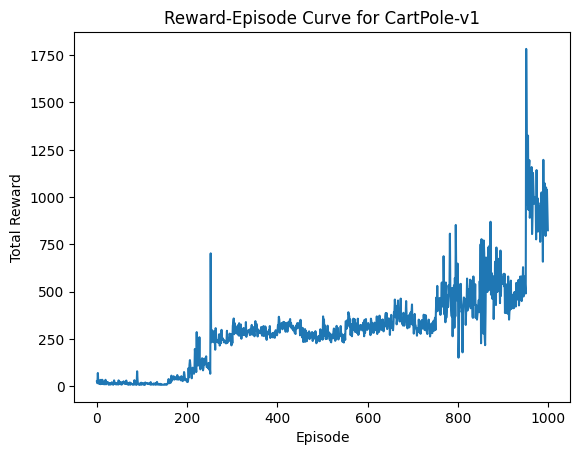

In [95]:
plt.plot(Reward)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Reward-Episode Curve for CartPole-v1")
plt.show()

In [96]:
def visualize_agent(env, network):
    state = tuple(env.reset()[0])
    env.render()
    for t in range(1000):
        action = select_action(state, network, 0)
        env.render()
        next_state, _, done, _, _ = env.step(action)
        next_state = tuple(next_state)
        if done:
            break
        state = next_state
        
        key = cv2.waitKey(1)
        if key == ord("q"):
            break
            
    env.close()

In [99]:
env = gym.make('CartPole-v1', render_mode="human")
visualize_agent(env, policy_net)